### 6주차 과제 수정본 ( abalone_regression의 모델을 참고한 회귀와 분류 )
과제 리뷰 후 수정한 코드

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                           classification_report, mean_squared_error, 
                           r2_score)
import matplotlib.pyplot as plt

# 데이터 로드
data = pd.read_csv('diabetes.csv')

##########################################################################
## 1. 이진 분류(Outcome 예측) 먼저 수행 ##
##########################################################################

# 분류용 데이터 준비
X_cls = data.drop('Outcome', axis=1).values
y_cls = data['Outcome'].values

# 데이터 표준화
scaler_cls = StandardScaler()
X_cls = scaler_cls.fit_transform(X_cls)

# 데이터 분할 (8:2)
X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42
)

# PyTorch 텐서 변환
cls_train_dataset = TensorDataset(
    torch.tensor(X_cls_train, dtype=torch.float32),
    torch.tensor(y_cls_train, dtype=torch.long)
)
cls_test_dataset = TensorDataset(
    torch.tensor(X_cls_test, dtype=torch.float32),
    torch.tensor(y_cls_test, dtype=torch.long)
)

# DataLoader 생성
batch_size = 32
cls_train_loader = DataLoader(cls_train_dataset, batch_size=batch_size, shuffle=True)
cls_test_loader = DataLoader(cls_test_dataset, batch_size=batch_size)

# 분류 모델 정의
class ClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
        
    def forward(self, x):
        return self.layers(x)

# 모델 초기화
cls_model = ClassificationModel()
cls_criterion = nn.CrossEntropyLoss()
cls_optimizer = optim.Adam(cls_model.parameters(), lr=0.001)

# 분류 학습 루프
print("## 분류 모델 학습 시작 ##")
for epoch in range(100):
    for inputs, labels in cls_train_loader:
        cls_optimizer.zero_grad()
        outputs = cls_model(inputs)
        loss = cls_criterion(outputs, labels)
        loss.backward()
        cls_optimizer.step()
    if (epoch+1) % 20 == 0:
        print(f'Epoch {epoch+1}/100 | Loss: {loss.item():.4f}')

# 분류 평가
with torch.no_grad():
    all_preds = []
    all_labels = []
    for inputs, labels in cls_test_loader:
        outputs = cls_model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

print("\n## 분류 결과 ##")
print(confusion_matrix(all_labels, all_preds))
print(classification_report(all_labels, all_preds))

## 분류 모델 학습 시작 ##
Epoch 20/100 | Loss: 0.2766
Epoch 40/100 | Loss: 0.1974
Epoch 60/100 | Loss: 0.3350
Epoch 80/100 | Loss: 0.1273
Epoch 100/100 | Loss: 1.2452

## 분류 결과 ##
[[74 25]
 [17 38]]
              precision    recall  f1-score   support

           0       0.81      0.75      0.78        99
           1       0.60      0.69      0.64        55

    accuracy                           0.73       154
   macro avg       0.71      0.72      0.71       154
weighted avg       0.74      0.73      0.73       154




## 회귀 모델 학습 시작 ##
Epoch 20/100 | Loss: 62.1029
Epoch 40/100 | Loss: 9.5016
Epoch 60/100 | Loss: 18.3830
Epoch 80/100 | Loss: 19.5747
Epoch 100/100 | Loss: 16.1801

## 회귀 결과 ##
MSE: 62.76
R²: 0.12


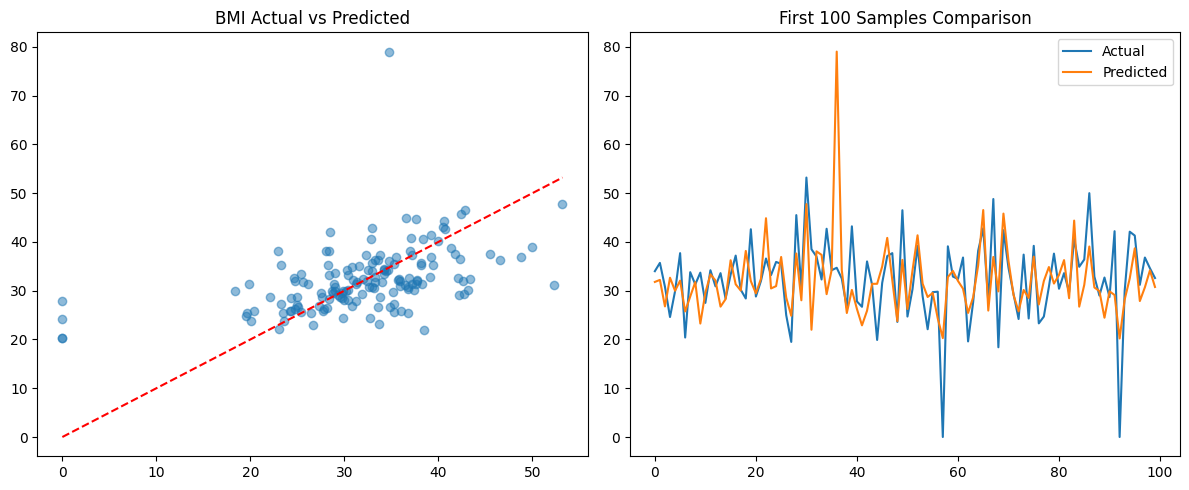

In [8]:
##########################################################################
## 2. 회귀(BMI 예측) 수행 ##
##########################################################################

# 회귀용 데이터 준비 (Outcome 삭제)
X_reg = data.drop(['BMI', 'Outcome'], axis=1).values
y_reg = data['BMI'].values.reshape(-1, 1)

# 데이터 표준화
scaler_reg = StandardScaler()
X_reg = scaler_reg.fit_transform(X_reg)

# 데이터 분할 (8:2)
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# PyTorch 텐서 변환
reg_train_dataset = TensorDataset(
    torch.tensor(X_reg_train, dtype=torch.float32),
    torch.tensor(y_reg_train, dtype=torch.float32)
)
reg_test_dataset = TensorDataset(
    torch.tensor(X_reg_test, dtype=torch.float32),
    torch.tensor(y_reg_test, dtype=torch.float32)
)

# DataLoader 생성
reg_train_loader = DataLoader(reg_train_dataset, batch_size=batch_size, shuffle=True)
reg_test_loader = DataLoader(reg_test_dataset, batch_size=batch_size)

# 회귀 모델 정의
class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(7, 64),  # 입력 차원 7
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        return self.layers(x)

# 모델 초기화
reg_model = RegressionModel()
reg_criterion = nn.MSELoss()
reg_optimizer = optim.Adam(reg_model.parameters(), lr=0.001)

# 회귀 학습 루프
print("\n## 회귀 모델 학습 시작 ##")
for epoch in range(100):
    for inputs, labels in reg_train_loader:
        reg_optimizer.zero_grad()
        outputs = reg_model(inputs)
        loss = reg_criterion(outputs, labels)
        loss.backward()
        reg_optimizer.step()
    if (epoch+1) % 20 == 0:
        print(f'Epoch {epoch+1}/100 | Loss: {loss.item():.4f}')

# 회귀 평가
with torch.no_grad():
    all_preds = []
    all_labels = []
    for inputs, labels in reg_test_loader:
        outputs = reg_model(inputs)
        all_preds.extend(outputs.numpy().flatten())
        all_labels.extend(labels.numpy().flatten())

print("\n## 회귀 결과 ##")
print(f'MSE: {mean_squared_error(all_labels, all_preds):.2f}')
print(f'R²: {r2_score(all_labels, all_preds):.2f}')

# 시각화
plt.figure(figsize=(12,5))

# 분류 결과
plt.subplot(1,2,1)
plt.scatter(all_labels, all_preds, alpha=0.5)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], 'r--')
plt.title('BMI Actual vs Predicted')

# 학습 곡선
plt.subplot(1,2,2)
plt.plot(all_labels[:100], label='Actual')
plt.plot(all_preds[:100], label='Predicted')
plt.title('First 100 Samples Comparison')
plt.legend()

plt.tight_layout()
plt.show()